In [4]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split


MAIN_PATH = '../data/traffic-signs-preprocessed/'

train_data = pd.read_pickle(os.path.join(MAIN_PATH, 'train.pickle'))

train_images, test_images, train_labels, test_labels = train_test_split(
    train_data['features'],
    train_data['labels'],
    train_size=0.8,
    random_state=42
)

labels_lookup = pd.read_csv(os.path.join(MAIN_PATH, 'label_names.csv'))["SignName"]

Lets print some random traffic signs with corresponding labels in NxN box

<Figure size 1100x1100 with 0 Axes>

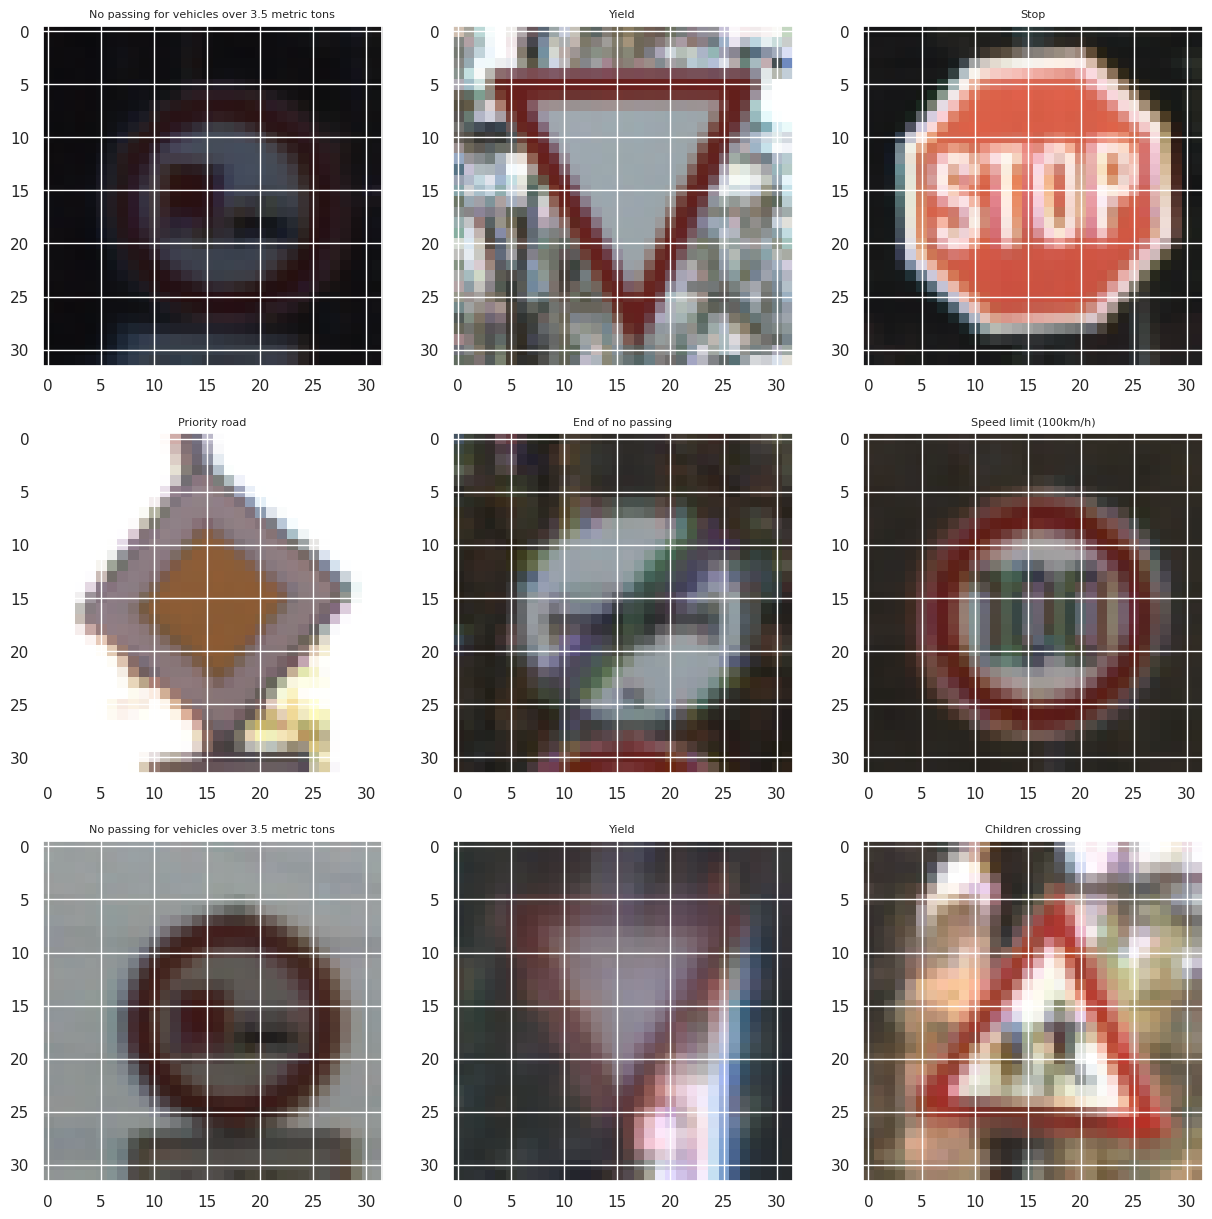

In [5]:
from matplotlib import pyplot as plt
from numpy import random


def print_traffic_signs(images, labels, n=3):
    plt.figure()
    f, axarr = plt.subplots(n, n, figsize=(15, 15))

    for i in range(0, n*n, n):
        indx = [random.randint(0, len(images)-1) for i in range(n)]
        for j in range(n):
            current_index = indx[j]
            current_name = labels_lookup[labels[current_index]]
            axarr[i // n, j].imshow(images[current_index])
            axarr[i // n, j].set_title(current_name, fontsize=8)

    plt.show()

print_traffic_signs(train_images, train_labels, n=3)


**Easy**

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
flatten_train_images = train_images.reshape(len(train_images), 32*32*3)

model.fit(
    flatten_train_images,
    train_labels
)

Lets predict and measure, we'll use default top-1 accuracy (default accuracy) and f1 score.

In [7]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np


flatten_test_images = test_images.reshape(len(test_images), 32*32*3)

test_prediction = model.predict(
    flatten_test_images
)


print(f"accuracy: {accuracy_score(test_prediction, test_labels)}")
print(f"f1: {f1_score(test_prediction, test_labels, average='weighted')}")

accuracy: 0.9461206896551724
f1: 0.9460285706724844


printing confusion matrix

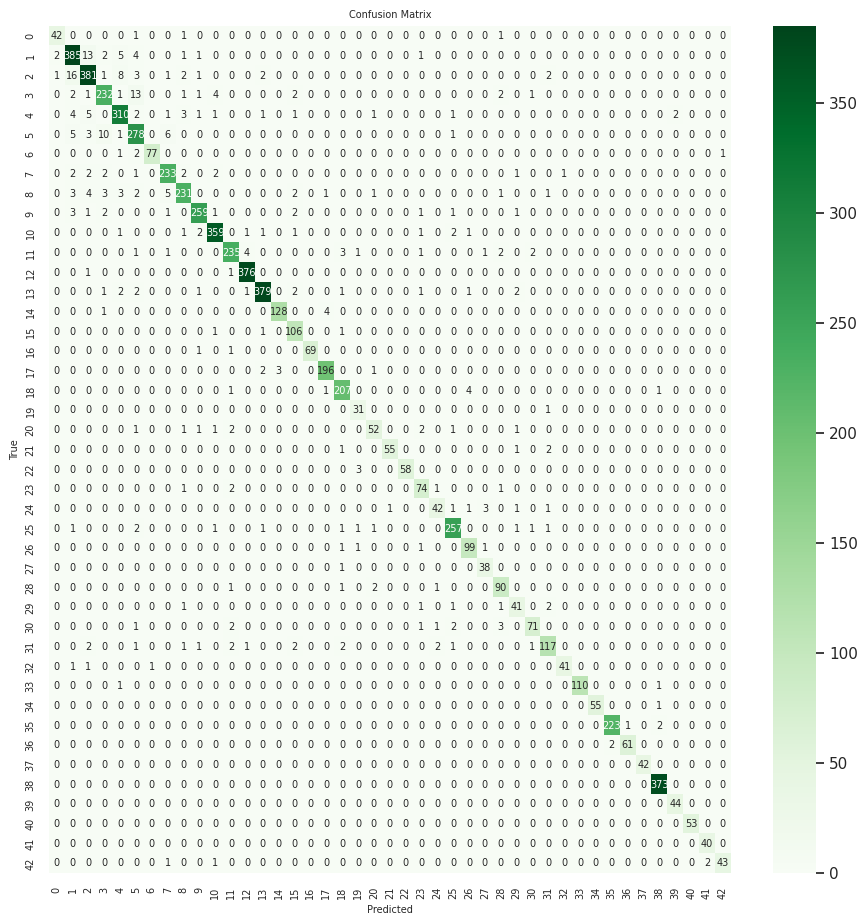

In [8]:
import seaborn as sns


def generate_confusion_matrix(matrix):
    matrix = matrix.astype('float')

    sns.set(rc={'figure.figsize': (11, 11)})
    figure = sns.heatmap(
        matrix,
        annot=True,
        cmap='Greens',
        fmt='.0f',
        annot_kws={"size": 7}
    )

    figure.tick_params(labelsize=7)

    plt.xlabel('Predicted', fontsize=7)
    plt.ylabel('True', fontsize=7)
    plt.title('Confusion Matrix', fontsize=7)
    plt.show()


df_confusion = confusion_matrix(test_prediction, test_labels)
generate_confusion_matrix(df_confusion)


most often there is confusion with 1 and 2 indexes, it's a .. (code is below)

In [9]:
print(labels_lookup[1], labels_lookup[2], sep="\n")

Speed limit (30km/h)
Speed limit (50km/h)


**Medium**

knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(flatten_train_images, train_labels)


In [11]:
knn_pred = knn_model.predict(flatten_test_images)

In [12]:
print(f"accuracy: {accuracy_score(knn_pred, test_labels)}")
print(f"f1: {f1_score(knn_pred, test_labels, average='weighted')}")

accuracy: 0.8458333333333333
f1: 0.8437323428172209


Naive Bayes classifier for multinomial models

In [13]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(flatten_train_images, train_labels)
nb_pred = nb_model.predict(flatten_test_images)


print(f"accuracy: {accuracy_score(nb_pred, test_labels)}")
print(f"f1: {f1_score(nb_pred, test_labels, average='weighted')}")

accuracy: 0.32600574712643676
f1: 0.29591923112281343


SVM

In [14]:
from sklearn.svm import SVC

# Linear kernel
lc_svm_model = SVC(kernel='linear')
lc_svm_model.fit(flatten_train_images, train_labels)
lc_svm_pred = lc_svm_model.predict(flatten_test_images)


print(f"accuracy: {accuracy_score(lc_svm_pred, test_labels)}")
print(f"f1: {f1_score(lc_svm_pred, test_labels, average='weighted')}")

accuracy: 0.9580459770114943
f1: 0.9579296671787372


In [15]:
# Polynomial kernel
pc_svm_model = SVC(kernel='poly')
pc_svm_model.fit(flatten_train_images, train_labels)
pc_svm_pred = pc_svm_model.predict(flatten_test_images)


print(f"accuracy: {accuracy_score(pc_svm_pred, test_labels)}")
print(f"f1: {f1_score(pc_svm_pred, test_labels, average='weighted')}")

accuracy: 0.7227011494252874
f1: 0.6862354572117074


In [16]:
# Radial Basis Function
rbfc_svm_model = SVC(kernel='rbf')
rbfc_svm_model.fit(flatten_train_images, train_labels)
rbfc_svm_pred = rbfc_svm_model.predict(flatten_test_images)


print(f"accuracy: {accuracy_score(rbfc_svm_pred, test_labels)}")
print(f"f1: {f1_score(rbfc_svm_pred, test_labels, average='weighted')}")

accuracy: 0.8834770114942528
f1: 0.8820881201677507


As we see, the logistic regression shows us the best result, although we can try to change the "max_iter" argument for better perfomance.

The worst result gives a naive bayes approach, I guess, it's because in that approach we assume, that all features r independent, but apparantly, in plain image we have a certain relationship between successive pixels, colors change gradually

**Hard**

in the future we will use only logistic regression, although it showed a slightly worse result than the svm linear kernel, it learns much faster

We'll act like this: consider all classes of pictures, define a variable n, which will indicate the number of pictures from each class.

We'll minimize n, so that the overall quality does not deteriorate too much; for this we'll use image augmentation

In [17]:
unique, counts = np.unique(train_labels, return_counts=True)
counts

array([ 142, 1555, 1616, 1018, 1397, 1312,  304, 1048, 1023, 1067, 1468,
        941, 1473, 1534,  560,  415,  283,  787,  861,  154,  243,  209,
        265,  373,  198, 1089,  430,  158,  382,  200,  301,  551,  174,
        491,  286,  840,  263,  143, 1490,  217,  230,  182,  166])

as we see, minimal count for all classes is 180, lets define n = 150



In [18]:
train_images.shape

(27839, 32, 32, 3)

In [19]:
from collections import defaultdict

k = 100

tmp_data = defaultdict(list)
for i, x in enumerate(train_images):
    if len(tmp_data[train_labels[i]]) < k:
        tmp_data[train_labels[i]].append(x)

tmp1_data, tmp1_labels = [], []
for key, stack in tmp_data.items():
    for item in stack:
        tmp1_data.append(item)
        tmp1_labels.append(key)

minimal_train, minimal_labels = np.array(tmp1_data), np.array(tmp1_labels)

now, lets augmentate it by using code provided at kaggle dataset page

In [20]:
minimal_train.shape

(4300, 32, 32, 3)

In [21]:
import cv2
import sys
sys.path.append('../data/traffic-signs-preprocessed')

from datasets_preparing import brightness_changing, \
                                rotation_changing, \
                                transformation_brightness_rotation, \
                                rotation_changing


def unison_shuffle(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]


def rgb_to_gray_image(img):
    y = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.merge((y, y, y))


aug_images, aug_labels = [], []

for i, x in enumerate(minimal_train):
    aug_images += [
                    x.astype(int),
                    rgb_to_gray_image(x).astype(int),
                    brightness_changing(x).astype(int),
                    rotation_changing(x).astype(int),
                    transformation_brightness_rotation(x).astype(int)
                ]
    aug_labels += [minimal_labels[i]]*5


aug_images, aug_labels = np.array(aug_images), np.array(aug_labels)
aug_images, aug_labels = unison_shuffle(aug_images, aug_labels)


print 4x4 box to ensure, that we've done alright

<Figure size 1100x1100 with 0 Axes>

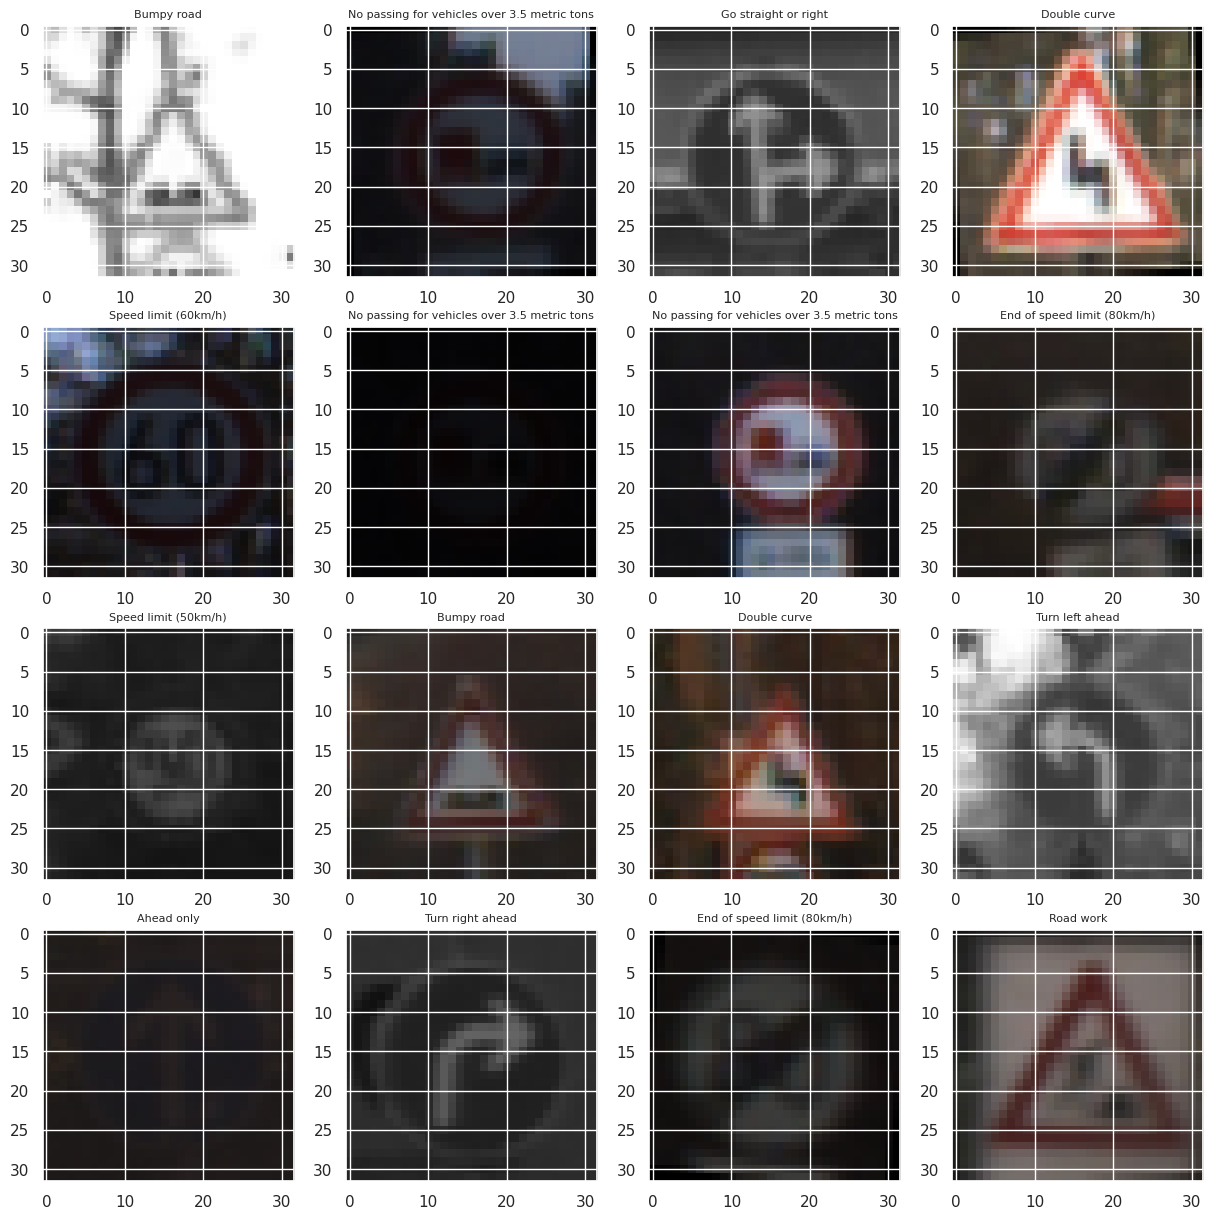

In [22]:
print_traffic_signs(
    aug_images,
    aug_labels,
    n=4
)




lets train the logistic regression & make predictions on initial test dataset

In [23]:
model = LogisticRegression(max_iter=200)
model.fit(aug_images.reshape(len(aug_images), 32*32*3), aug_labels)
test_prediction = model.predict(flatten_test_images)

In [24]:
print(f"accuracy: {accuracy_score(test_prediction, test_labels)}")
print(f"f1: {f1_score(test_prediction, test_labels, average='weighted')}")

accuracy: 0.8540229885057471
f1: 0.8527600233208693




**Conclusion**

leaving literally 150 pictures of each class, we already get a very good top-1 accuracy, doubtless, we can improve this result by making better quality augmentation, it turns out that to achieve a good result it is not necessary to take 500-800 pictures of different classes, 150-200 is enough
